# Imports

In [86]:
!pip install langdetect
!pip install biobert-embedding

import json
import nltk
import matplotlib

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from nltk import RegexpTokenizer, pos_tag
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
from sklearn.neighbors import NearestNeighbors
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from langdetect import detect
from biobert_embedding.embedding import BiobertEmbedding
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

nltk.download('punkt')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [87]:
%cd /content/drive/My Drive/NLP/Project
%ls

/content/drive/My Drive/NLP/Project
 app.log
 biobert_v1.1_pubmed_pytorch_model/
 dict.json
 Exemples/
 improved_cluster_tsne.png
 information_extraction_colab.ipynb
 information_extraction.ipynb
 IRTM_Proposal.pdf
 metadata.csv
 noncomm_use_subset/
 Ressources/
'Screenshot 2020-04-15 at 20.56.34.png'
'Screenshot 2020-04-15 at 22.41.45 (2).png'
'Screenshot 2020-04-15 at 22.54.48 (2).png'
 t-sne_covid19.png
 tulkens2019.pdf


# Preprocessing

In [88]:
df = pd.read_csv('metadata.csv')
df = pd.concat([df['title'],df['abstract']], axis=1)
df = df.dropna(axis=0)
abstract = df['abstract'][0]
df.shape

(42203, 2)

In [89]:
df.head()

,title,abstract
0,Airborne rhinovirus detection and effect of ul...,"BACKGROUND: Rhinovirus, the most common cause ..."
1,Discovering human history from stomach bacteria,Recent analyses of human pathogens have reveal...
2,A new recruit for the army of the men of death,"The army of the men of death, in John Bunyan's..."
3,Association of HLA class I with severe acute r...,BACKGROUND: The human leukocyte antigen (HLA) ...
4,A double epidemic model for the SARS propagation,BACKGROUND: An epidemic of a Severe Acute Resp...


In [90]:
lang = []
n = []
for index in df.index:
  n.append(len(word_tokenize(df['abstract'][index])))
  try:
    lang.append(detect(df['abstract'][index]))
  except:
    lang.append('error')
df['lang']=lang
df['n']=n

print('Languages:', df['lang'].value_counts())

Languages: en       41682
fr         206
es         170
de          55
nl          50
it          14
pt          10
ca           4
zh-cn        4
et           3
error        1
ro           1
af           1
ja           1
no           1
Name: lang, dtype: int64


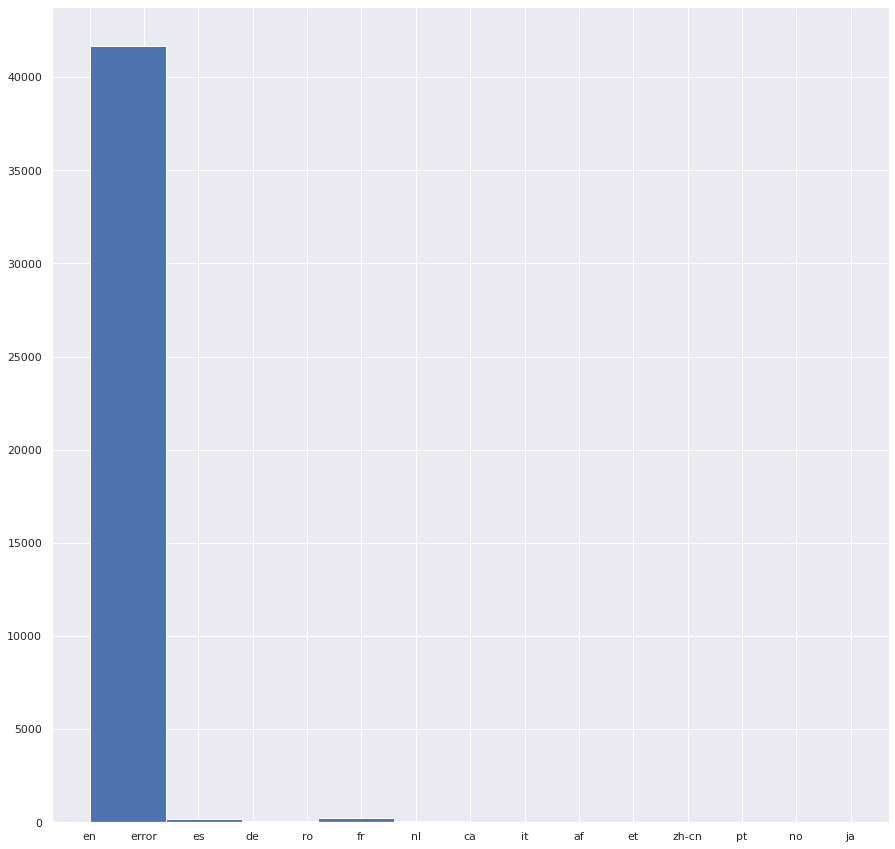

In [91]:
df.lang.hist()

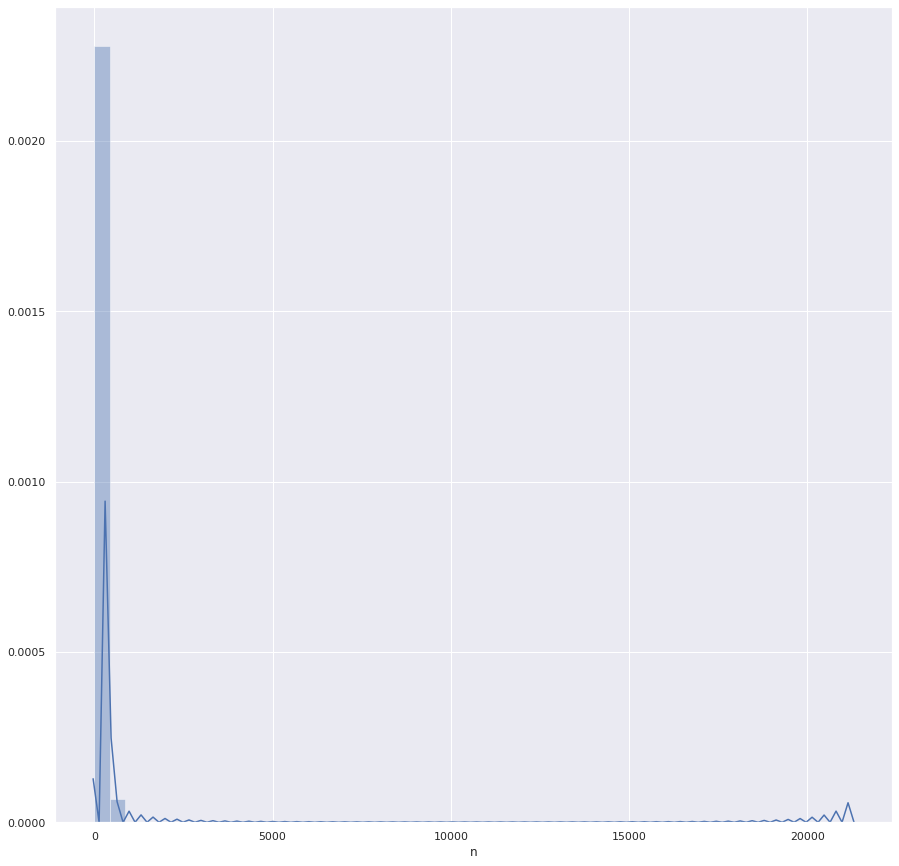

In [92]:
sns.distplot(df.n)

In [93]:
df.n.describe()

count    42203.000000
mean       224.896879
std        162.912451
min          1.000000
25%        158.000000
50%        219.000000
75%        282.000000
max      21271.000000
Name: n, dtype: float64

In [94]:
df = df[df.n<300]
df = df[df.lang=='en']
df = df.sample(n=1000, random_state=42)
df.shape

(1000, 4)

# Vectorization

## TF-IDF

In [0]:
# for key in d.keys():
#   if type(d[key]) is not float:
#     l = d[key].lower()
#     # remove punctuation
#     tokens = tk.tokenize(l)
#     # remove stop words
#     stop_words = set(stopwords.words('english')) 
#     tokens = [w for w in tokens if not w in stop_words]
#     # stematization
#     stemmed = []
#     for word in tokens:
#       stemmed.append(ps.stem(word))
#     # save
#     d[key] = ' '.join(stemmed)

In [96]:
# Lemmatization
lemmatizer = WordNetLemmatizer()
for i in df.index:
  tokens = word_tokenize(df['abstract'][i])
  stemmed = []
  for word in tokens:
    stemmed.append(lemmatizer.lemmatize(word))
  df['abstract'][i] = ' '.join(stemmed)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [0]:
vectorizer = TfidfVectorizer(
    # if different encoding
    decode_error='ignore',
    # remove accent
    strip_accents='ascii',
    # to lower case
    lowercase=True,
    # remove stopwords
    stop_words='english',
    # analyse at the word level
    analyzer='word',
    # consider words between 2 and 20 char
    token_pattern=r'\w{2,20}',
    # number of features
    max_features=50,
    # normalize the tf-idf to make the vector have a unit norm
    norm='l2'
)
embedding = vectorizer.fit_transform(df['abstract'])
embedding_arr = embedding.toarray()
feature_names = vectorizer.get_feature_names()

In [0]:
# # put everything in a dic
# i=0
# dic={}
# for row in X_arr:
#     dic[i] = {key : value for value, key in zip(row, feature_names)}
#     i+=1
# jayson = json.dumps(dic)
# f = open("dict.json","w")
# f.write(jayson)
# f.close()

In [0]:
# # read from dictionnary
# with open("dict.json","r") as json_file:
#   d = json.load(json_file)
# d

In [111]:
embedding_arr.shape

(1000, 50)

# Dimensionality reduction

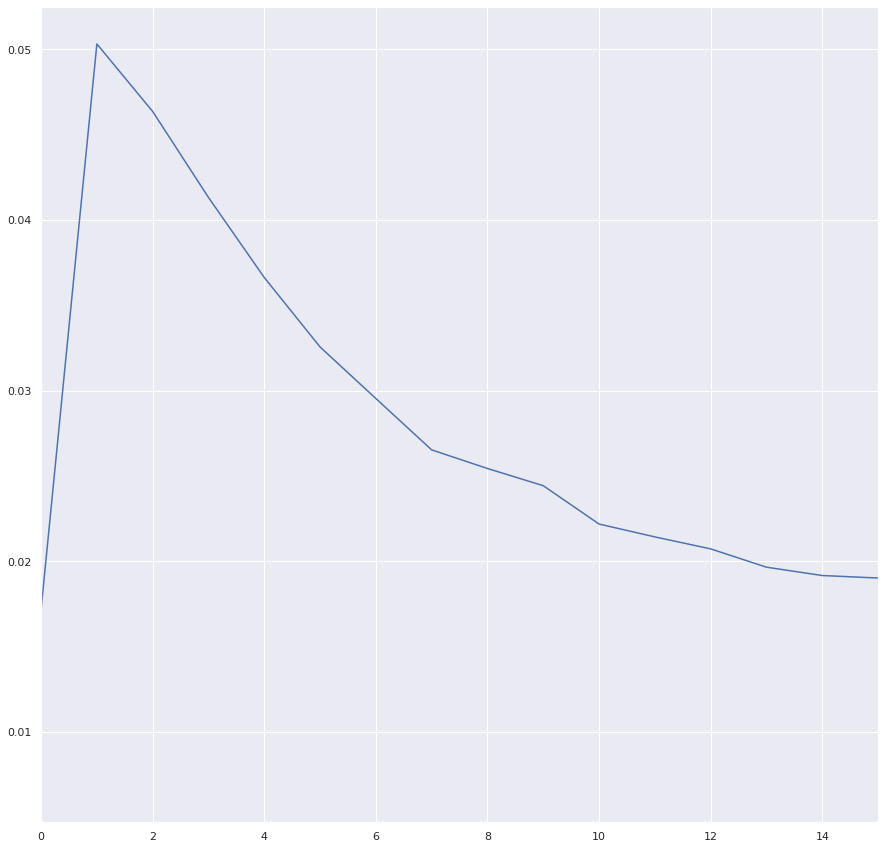

In [112]:
tsvd = TruncatedSVD(n_components=49, random_state=42)
tsvd.fit_transform(embedding_arr)
plt.xlim(0,15)
plt.plot(tsvd.explained_variance_)
# embedding.shape

SVD is about finding the best projection to project our data. The best means we want to make sure the reconstruction error is minimized. To make the dimensionality reduction, the trick is to put some of the singular values to zero. If you keep 2 SV, you will project to 2 dimensions. The Frobenius norm represent the squared difference between the old 
matrix and the reconstruction.
if A = U.S.M (U=user-to-concept, S=SV, M=movies-to-concept)

U.S will then give the coordinate of the users on the different axis.

see : https://www.youtube.com/watch?v=UyAfmAZU_WI

Wen you plot the entropy as a function of k, different dimensions lead to different graphs. As we want to locate the elbow of the graph, lets see what is the optimal number of dimension according to the graph...

- with (100,5) --> 10
- with (100,10) --> 12
- with (100,20) --> 15

The more dimensions you give to KNN, the longer the runtime and the less clean is the elbow shape, I would go for sth between 5 and 10.


In [113]:
tsvd = TruncatedSVD(n_components=5, random_state=42)
embedding_reduced = tsvd.fit_transform(embedding_arr)
embedding_reduced.shape

(1000, 5)

In [0]:
scaled_embedding_reduced = StandardScaler().fit_transform(embedding_reduced)

# Clustering

## Partitioning based: KNN

In [0]:
# Copy data from dimensionality reduction section
X = scaled_embedding_reduced

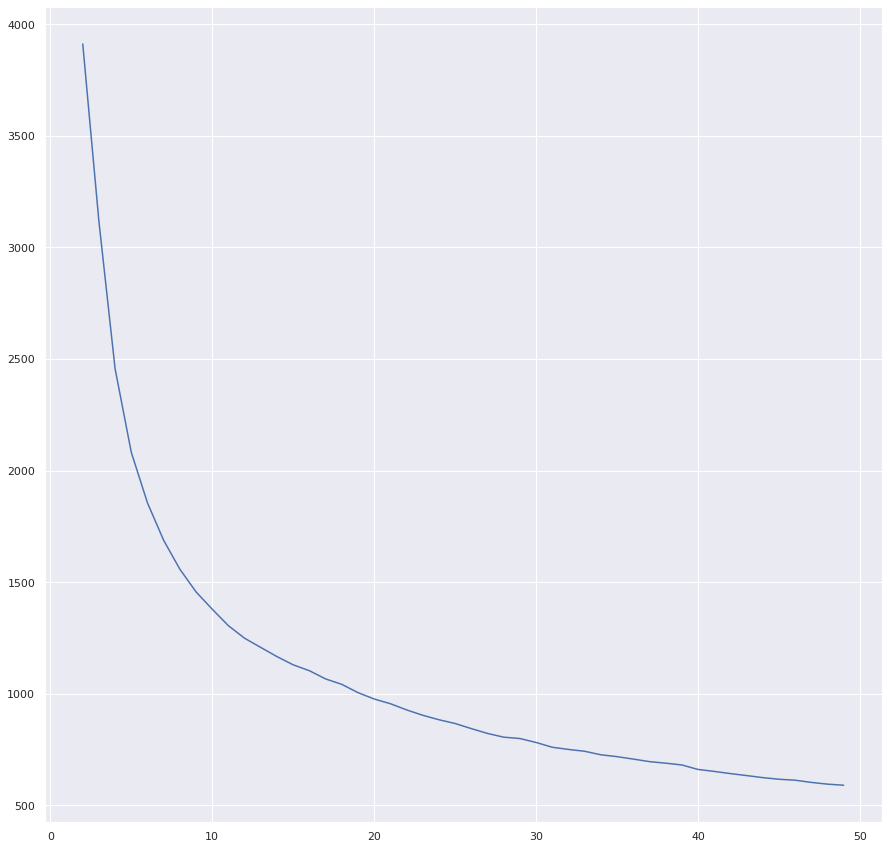

In [316]:
# run kmeans with many different k
inertie = []
k_set = range(2, 50)
for k in k_set:
    km = KMeans(n_clusters=k, random_state=42).fit(X)
    inertie.append(km.inertia_)
plt.plot(k_set, inertie)

In [0]:
k = 10
kmeans = KMeans(n_clusters=k, random_state=42)
l = kmeans.fit_predict(X)

In [0]:
def plot2D(k, X, l):
  sns.set(rc={'figure.figsize':(15,15)})
  palette = sns.hls_palette(n_colors=k, l=.4, s=.9)

  perplexities = [50, 100, 200]

  for p in perplexities:
    print('\n =============== Summary with perplexity :',p,'===============')
    tsne = TSNE(verbose=1, perplexity=p, random_state=42)
    proj = tsne.fit_transform(X)
    sns.scatterplot(proj[:,0], proj[:,1], hue=l, legend='full', palette=palette)
    plt.show()

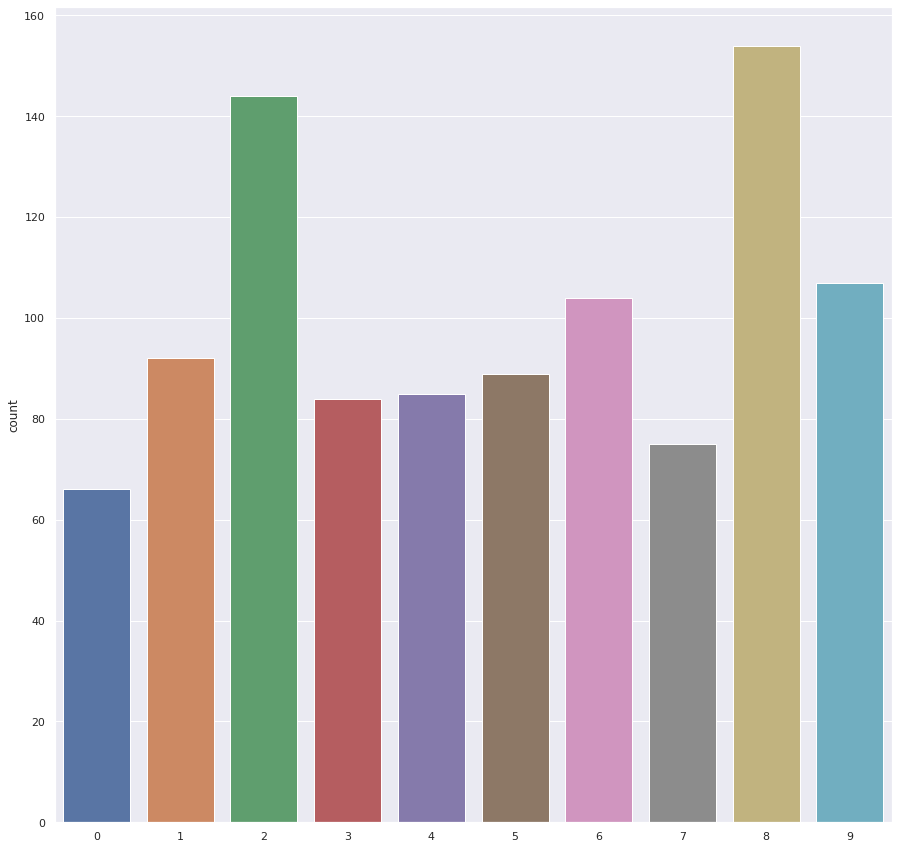

In [319]:
sns.countplot(l)

In [0]:
plot2D(k, X, l)

t-Distributed Stochastic Neighbor Embedding (t-SNE) reduces dimensionality while trying to keep similar instances close and dissimilar instances apart. 
- start with the original scatterplot, determine the similarity between each points using a Gaussian distribution (with variance proportional to the density of the cluster), and then scale to add up to one. Also, the similarity is averaged in both direction (as s(a,b)!=s(b,a) )
- randomly project them on a 1 dimensional space
- move points one at the time to find the cluster back, at each steps, a point on the line is attracted by point it is near to in the original scatterplot, and repelled by points it is far from in the 1 dimensional line (similarity in the number line is based on a t-distribution, hence the name, and it is scaled for the same reasons as above)...

see : https://www.youtube.com/watch?v=NEaUSP4YerM


Perplexity really should be smaller than the number of points. 

The t-SNE algorithm adapts its notion of “distance” to regional density variations in the data set. As a result, it naturally expands dense clusters, and contracts sparse ones.  Result : you cannot see relative sizes of clusters in a t-SNE plot.

The distances between well-separated clusters in a t-SNE plot may mean nothing.

A classic pitfall is thinking you see patterns in what is really just random data. Recognizing noise when you see it is a critical skill, but it takes time to build up the right intuitions. A tricky thing about t-SNE is that it throws a lot of existing intuition out the window. Low perplexity values often lead to this kind of distribution (clumps in random noize). --> we should keep the perplexity pretty high.

More accurate than what any linear project can produce !



see : https://distill.pub/2016/misread-tsne/

## Density based: DBSCAN


The DBSCAN algorithm views clusters as areas of high density separated by areas of low density. Due to this rather generic view, clusters found by DBSCAN can be any shape, as opposed to k-means which assumes that clusters are convex shaped. Sensitive to the parameters eps (maximum radius of the neightborhood) and min_samples (min number of points in the eps neightborhood necessary to define a core point). 

see: https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc

In [0]:
# copy data from the dimensionality reduction section
X = scaled_embedding_reduced

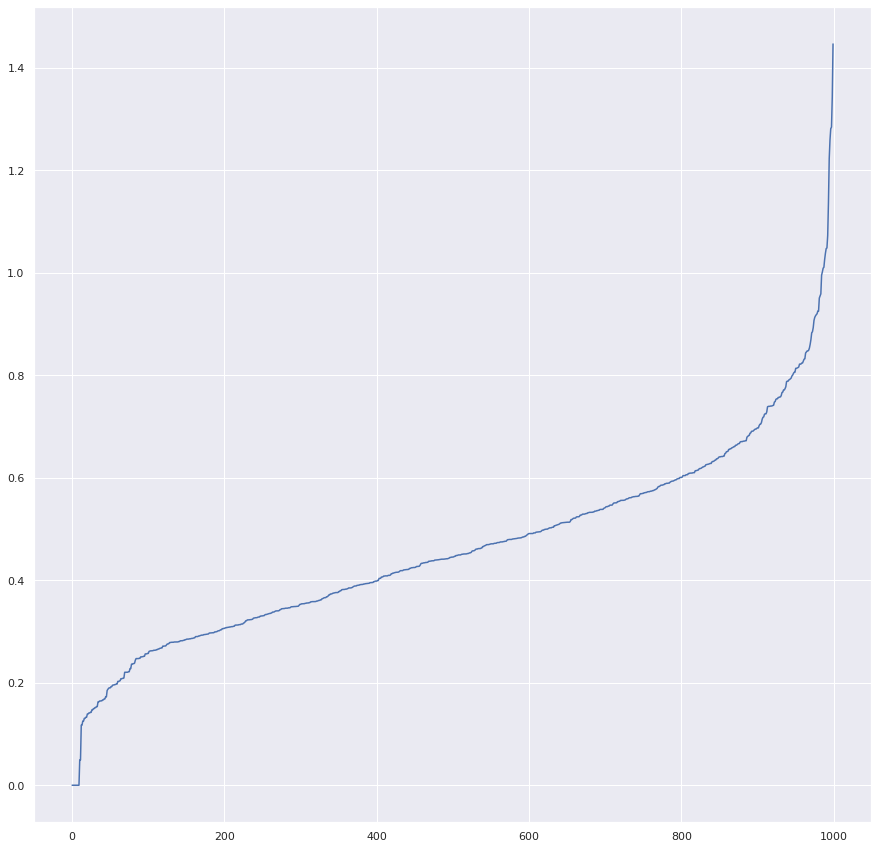

In [306]:
# find an optimal eps
nn = NearestNeighbors(n_neighbors=k)
nbrs = nn.fit(X)
distances, indices = nn.kneighbors(X)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [307]:
# search of eps
opt_eps = 0
opt_sil = -1
for e in range(50,80):
  e = e/100
  db = DBSCAN(eps=e, min_samples=10).fit(X)
  l = db.labels_
  sil = metrics.silhouette_score(X, l)
  if sil >= opt_sil:
    opt_sil = sil
    opt_eps = e
print('Optimal eps:', opt_eps)
print('Silouette coef:',opt_sil)

Optimal eps: 0.79
Silouette coef: -0.022591998267144052


- The Silhouette Coefficient is generally higher for convex clusters than other concepts of clusters, such as density based clusters like those obtained through DBSCAN.

- The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster

- The score is bounded between -1 for incorrect clustering and +1 for highly dense clustering. Scores around zero indicate overlapping clusters.

In [0]:
 # check if it is not redundant
db = DBSCAN(eps=opt_eps, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
l = db.labels_

In [0]:
# Number of clusters in labels, ignoring noise if present
k = len(set(labels)) - (1 if -1 in labels else 0)
noise = list(labels).count(-1)

In [310]:
print('Estimated number of clusters: %d' % k)
print('Estimated number of noise points: %d' % noise)
print("Silhouette Coefficient: %0.3f"% metrics.silhouette_score(X, l))

Estimated number of clusters: 6
Estimated number of noise points: 466
Silhouette Coefficient: -0.023


In [311]:
# remove outliers
print(X.shape)
print(l.shape)

X_df = pd.DataFrame(X)
X_df['l']=l
X_df = X_df[X_df.l !=-1]
X = np.array(X_df.drop(columns='l'))
l = np.array(X_df.l)
print(X.shape)
print(l.shape)

(1000, 5)
(1000,)
(673, 5)
(673,)


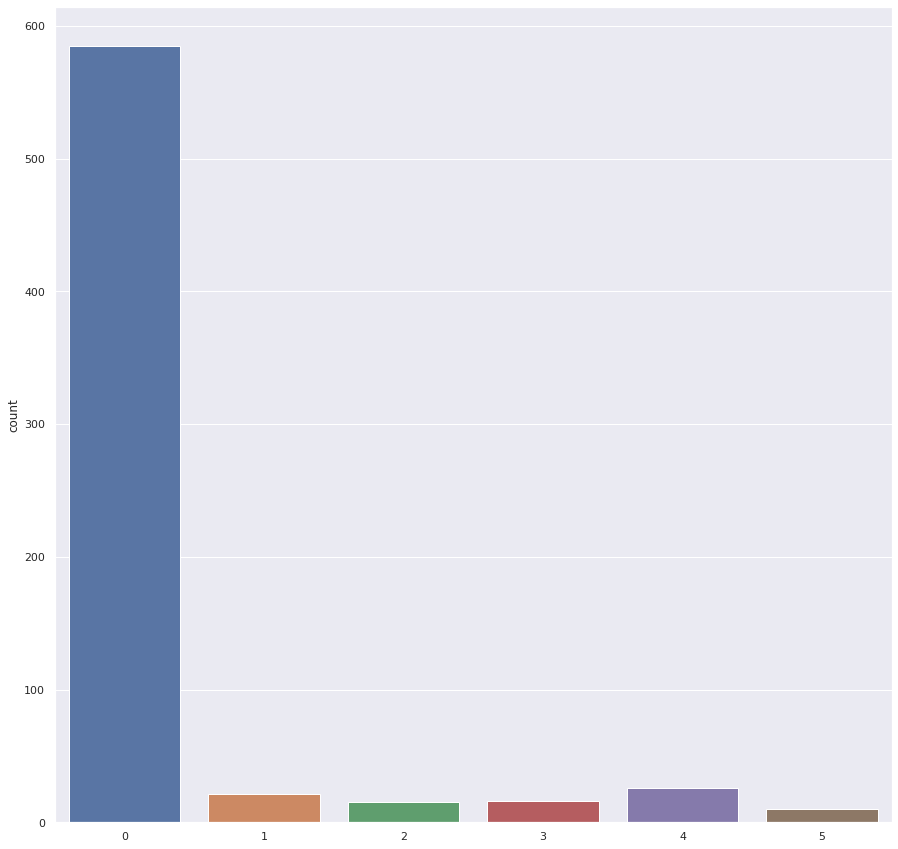

In [314]:
sns.countplot(l)

DEBUG, k= 6
DEBUG LEN5PALETTE° 6

 =============== Summary with perplexity : 50 ===============
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 673 samples in 0.001s...
[t-SNE] Computed neighbors for 673 samples in 0.040s...
[t-SNE] Computed conditional probabilities for sample 673 / 673
[t-SNE] Mean sigma: 0.629699
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.970280
[t-SNE] KL divergence after 1000 iterations: 0.658019


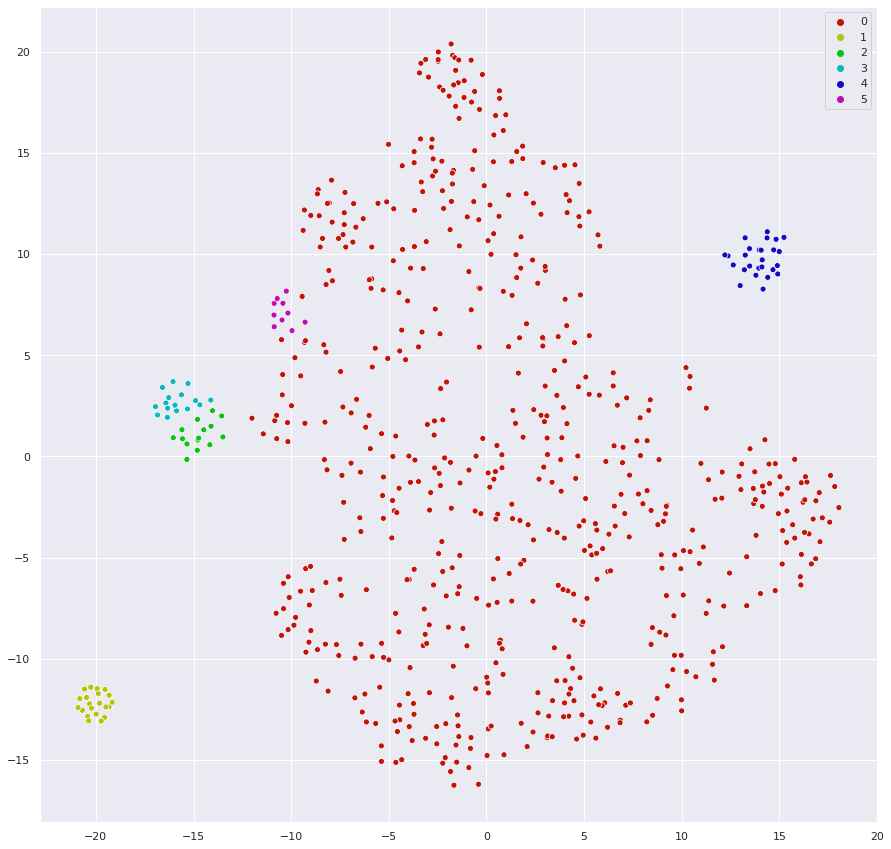


 =============== Summary with perplexity : 100 ===============
[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 673 samples in 0.018s...
[t-SNE] Computed neighbors for 673 samples in 0.067s...
[t-SNE] Computed conditional probabilities for sample 673 / 673
[t-SNE] Mean sigma: 0.802457
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.203274
[t-SNE] KL divergence after 1000 iterations: 0.579068


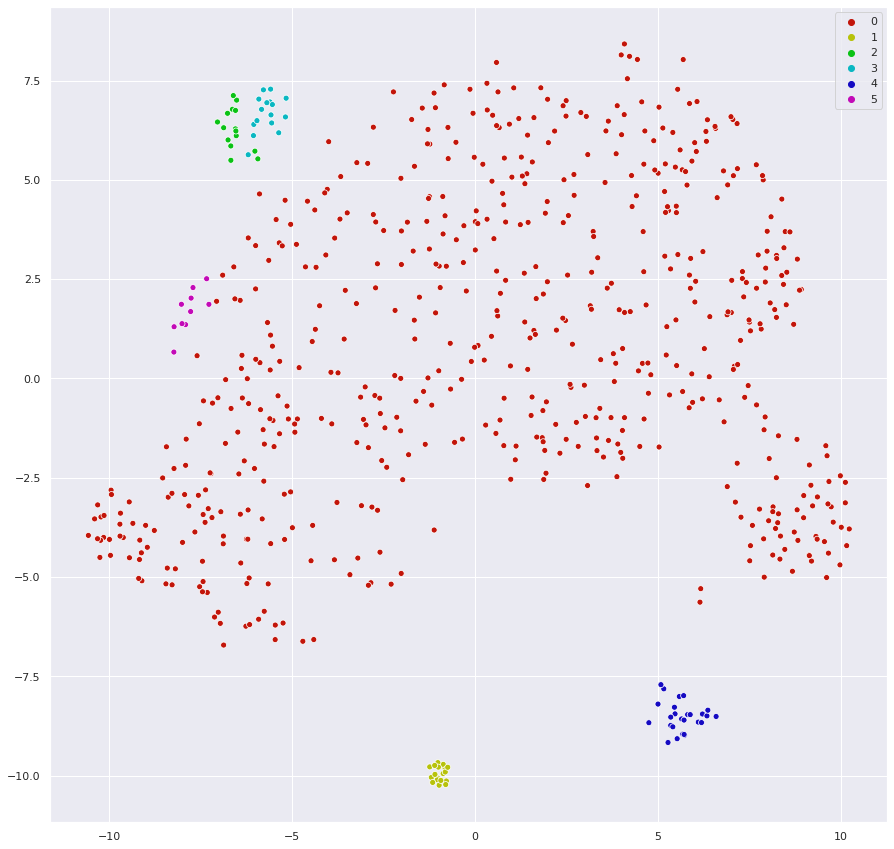


 =============== Summary with perplexity : 200 ===============
[t-SNE] Computing 601 nearest neighbors...
[t-SNE] Indexed 673 samples in 0.001s...
[t-SNE] Computed neighbors for 673 samples in 0.133s...
[t-SNE] Computed conditional probabilities for sample 673 / 673
[t-SNE] Mean sigma: 1.060688
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.678337
[t-SNE] KL divergence after 750 iterations: 0.293565


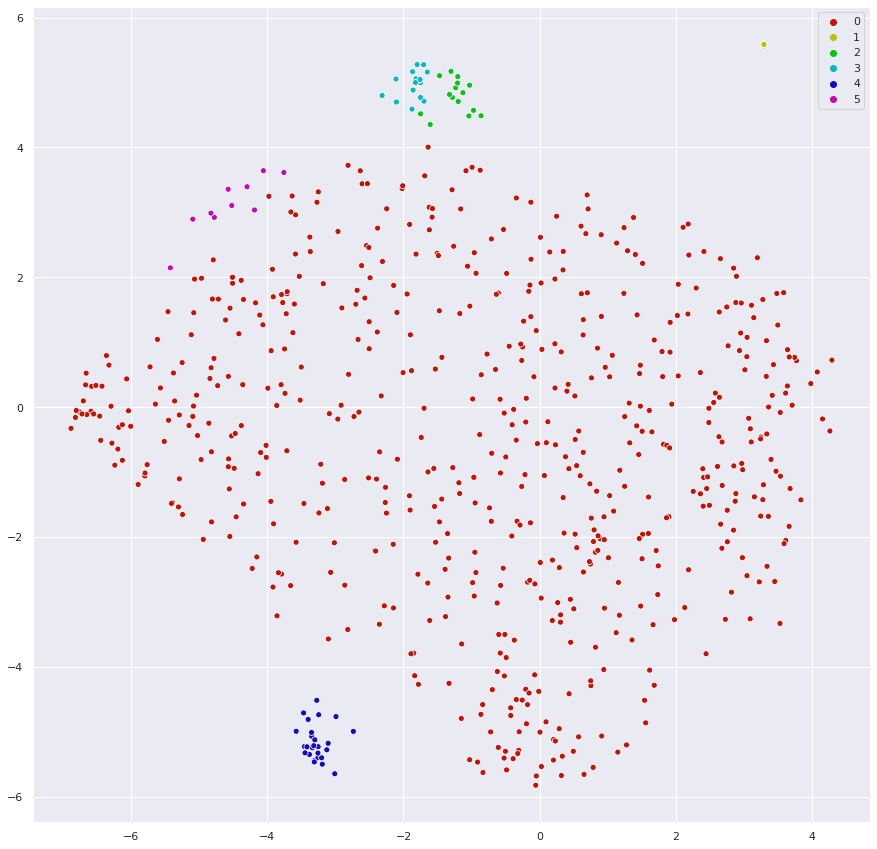

In [312]:
plot2D(k, X, l)

## Hierarchical: Agglomerative clustering

# Triplet extraction

In [0]:
# ngram 
# NER
abstract = df['abstract'][0]
tokens = nltk.word_tokenize(abstract)

In [0]:
# POS tagger which uses the Penn Treebank tagset
nltk.download('averaged_perceptron_tagger')
tagged_tokens = pos_tag(token)

In [0]:

#Define your grammar using regular expressions
grammar = ('''
  NP: {<DT>?<JJ>*<NN>} # NP
      }abstract{      # Chink sequences of VBD and IN
''')
chunkParser = nltk.RegexpParser(grammar)
tree = chunkParser.parse(tagged_tokens)

In [0]:
print(tree)

# Vectorization2: BERT

In [0]:
# from biobert_embedding.embedding import BiobertEmbedding

# biobert = BiobertEmbedding()
# word_embeddings = biobert.word_vector(abstract)
# sentence_embedding = biobert.sentence_vector(abstract)

# print("Text Tokens: ", biobert.tokens)
# print ('Shape of Word Embeddings: %d x %d' % (len(word_embeddings), len(word_embeddings[0])))
# print("Shape of Sentence Embedding = ",len(sentence_embedding))


In [0]:
biobert = BiobertEmbedding()
word_embeddings = biobert.word_vector(df['abstract'][0])

In [0]:
dim = (len(word_embeddings), len(word_embeddings[0]))

In [0]:
arr = np.zeros(shape=dim)
for i in df.index:
  np.append(arr, np.array(df['abstract'][i]))
arr

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])